In [1]:
!pip install -U evaluate
!pip install -U datasets
!pip install -U accelerate
!pip install -U transformers
!pip install scikit-learn matplotlib

import os
import torch
import numpy as np
import pandas as pd
import evaluate
import accelerate
import matplotlib.pyplot as plt
from data_preprocessing import CustomDataset
from transformers import AutoTokenizer, pipeline
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import TrainerCallback
from models import BaseModel, CustomClassifier, SimpleTransformerModel, EnsembleModel

print(torch.cuda.is_available())

  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.17-py311-none-any.whl.metadata (7.2 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
  Using cached pyarrow-19.0.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
INFO: pip is looking at multiple versions of huggingface-hub to determine which version is compatible with other

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [2]:
class GradualUnfreezeCallback(TrainerCallback):
    def __init__(self, model, enable_unfreezing, total_epochs, unfreeze_schedule):
        self.model = model
        self.enable_unfreezing = enable_unfreezing
        self.total_epochs = total_epochs
        self.unfreeze_schedule = unfreeze_schedule
        self.unfrozen_layers = 0  # Tracks the number of unfrozen layers

        # Freeze all layers except classification head initially
        if self.enable_unfreezing:
            base_model = getattr(self.model.pretrained_model, "base_model", self.model.pretrained_model)
            classifier = getattr(self.model.pretrained_model, "classifier", None) or getattr(self.model, "final_classifier", None)

            for param in base_model.parameters():
                param.requires_grad = False
            if classifier:
                for param in classifier.parameters():
                    param.requires_grad = True

    def on_init_end(self, args, state, control, **kwargs):
        """Required method to avoid the AttributeError."""
        pass  # No action needed on initialization

    def on_epoch_begin(self, args, state, control, **kwargs):
        """Unfreezes layers based on the predefined schedule."""
        if not self.enable_unfreezing or self.unfrozen_layers >= len(self.unfreeze_schedule):
            return  # Either all layers are unfrozen or unfreezing is disabled

        current_epoch = int(state.epoch)  # Ensure it's an integer
        next_unfreeze_epoch = self.unfreeze_schedule[self.unfrozen_layers]

        if current_epoch >= next_unfreeze_epoch:
            # Unfreeze one more layer
            layers = list(self.model.pretrained_model.base_model.children())[::-1]  # Reverse list to start from last layers
            if self.unfrozen_layers < len(layers):
                for param in layers[self.unfrozen_layers].parameters():
                    param.requires_grad = True

                self.unfrozen_layers += 1
                print(f"Epoch {current_epoch}: Unfroze layer {self.unfrozen_layers}")

In [3]:
model_checkpoint = "bert-base-uncased"
max_len = 512

dataset = CustomDataset('HateSpeechDatasetBalanced.csv', model_checkpoint=model_checkpoint)
train_dataset, val_dataset, test_dataset = dataset.get_splits()

tokenizer = dataset.get_tokenizer()
vocab_size = tokenizer.vocab_size

print(train_dataset, val_dataset, test_dataset)

Map: 100%|██████████| 726119/726119 [03:33<00:00, 3406.41 examples/s]


Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 580895
}) Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 72612
}) Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 72612
})


In [13]:
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2, hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
model = BaseModel(model_checkpoint, num_labels=2, hidden_dropout_prob=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.resize_token_embeddings(len(dataset.get_tokenizer())) # need to resize due to new tokens added

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2, hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
#FOR SimpleTransformerModel THAT HAS WORD EMBEDDING WITHIN
model = SimpleTransformerModel(vocab_size, num_labels=2, dropout=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2, hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
#FOR SimpleTransformerModel THAT HAS WORD EMBEDDING WITHIN
model1 = EnsembleModel('bert-base-uncased', 'distilbert-base-uncased', num_labels=2, hidden_dropout_prob=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)
model1.resize_token_embeddings(len(dataset.get_tokenizer()))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


TypeError: DistilBertForSequenceClassification.__init__() got an unexpected keyword argument 'hidden_dropout_prob'

In [5]:
metric_name = 'f1'
model_name = model_checkpoint.split("/")[-1]

total_epochs = 1
args = TrainingArguments(
    f"./snapshots/{model_name}-finetuned",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=total_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
    fp16=True
)

In [6]:
metric = evaluate.load(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="micro")

In [7]:
def train_model(model, args, train_dataset, val_dataset, enable_unfreezing, total_epochs, unfreeze_schedule):
    gradual_unfreeze_callback = GradualUnfreezeCallback(
        model, enable_unfreezing, total_epochs, unfreeze_schedule
    )

    trainer = Trainer(
        model,
        args,
        train_dataset=train_dataset, # Explicitly name the arguments
        eval_dataset=val_dataset,   # Explicitly name the arguments
        compute_metrics=compute_metrics, # Explicitly name the arguments
        tokenizer=tokenizer,
        callbacks=[gradual_unfreeze_callback]
    )

    trainer.train()

    return trainer

In [8]:
train_log = train_model(model=model,
                        args=args,
                        train_dataset=train_dataset,
                        val_dataset=val_dataset,
                        enable_unfreezing=False,
                        total_epochs=total_epochs,
                        unfreeze_schedule=[1,2]
                        )

/tmp/ipykernel_80/2709245166.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.445600,0.438855,0.797898


In [9]:
def plot_losses(trainer):
    logs = trainer.state.log_history
    train_loss = [log["loss"] for log in logs if "loss" in log and "epoch" in log]
    val_loss = [log["eval_loss"] for log in logs if "eval_loss" in log and "epoch" in log]
    
    train_epochs = [log["epoch"] for log in logs if "loss" in log and "epoch" in log]
    val_epochs = [log["epoch"] for log in logs if "eval_loss" in log and "epoch" in log]

    plt.figure(figsize=(8, 5))
    plt.plot(train_epochs, train_loss, label="Training Loss")
    plt.plot(val_epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_eval_metric(trainer, metric_name='eval_f1'):
    logs = trainer.state.log_history
    metric_vals = [log[metric_name] for log in logs if metric_name in log and "epoch" in log]
    epochs = [log["epoch"] for log in logs if metric_name in log and "epoch" in log]

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, metric_vals, label=f"{metric_name.upper()} Score")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name.upper())
    plt.title(f"{metric_name.upper()} Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

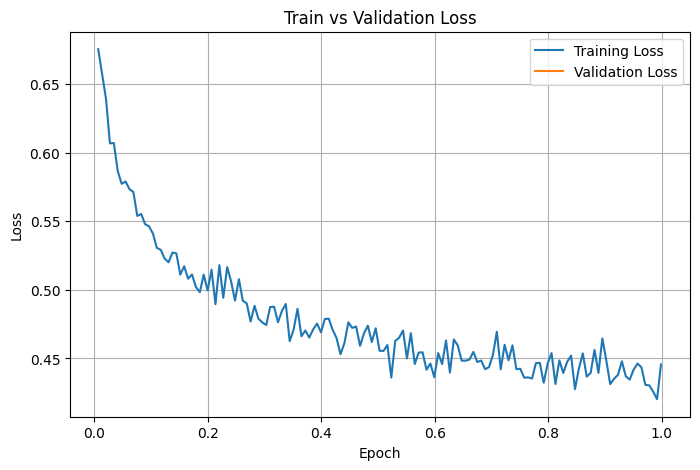

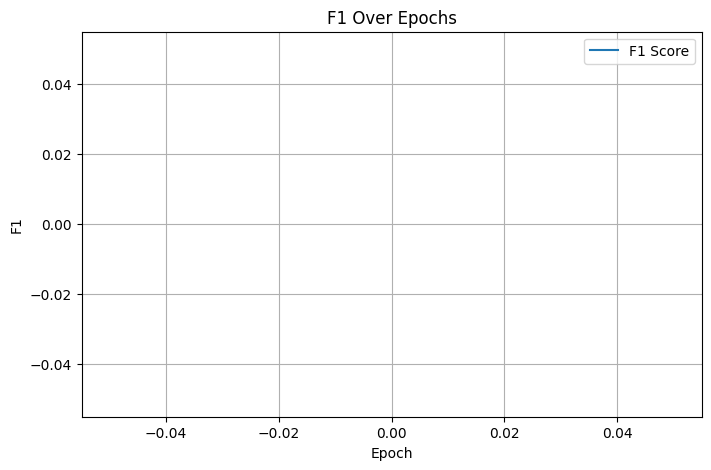

In [10]:
plot_losses(train_log)
plot_eval_metric(train_log, metric_name)

In [37]:
train_log.save_model("./models/myFinetunedModel") # for saving your model

In [40]:
classifier = pipeline("text-classification", model=model, tokenizer=dataset.get_tokenizer(), device="cuda:0")
results = classifier(test_dataset['text'], max_length=max_len, padding="max_length", truncation=True)
dfResults = pd.DataFrame.from_dict(results)
dfResults['label'] = dfResults['label'].str.replace('LABEL_','')
f1 = metric.compute(predictions=dfResults['label'].tolist(), references=test_dataset['label'], average='micro')
print(f1)

AttributeError: 'SimpleTransformerModel' object has no attribute 'config'

In [17]:
class CustomTorchDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # Ensure the inputs are tensors and casted to long (as required by nn.Embedding)
        input_ids = torch.tensor(item['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(item['attention_mask'], dtype=torch.long)
        label = torch.tensor(item['label'], dtype=torch.long)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label,
            'text': item['text']
        }

In [19]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader

test_torch_dataset = CustomTorchDataset(test_dataset)
test_loader = DataLoader(test_torch_dataset, batch_size=32)

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)

    all_preds, all_labels, all_texts, all_losses = [], [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            texts = batch['text']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs['logits']
            loss = outputs['loss']

            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_texts.extend(texts)
            all_losses.append(loss.item())

    avg_loss = sum(all_losses) / len(all_losses)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    results_df = pd.DataFrame({
        'text': all_texts,
        'label': all_labels,
        'prediction': all_preds
    })

    return avg_loss, accuracy, f1, results_df

# Run evaluation
loss, acc, f1, df_results = evaluate_model(model, test_loader, device)

print(f"Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}")
print(df_results.head())

Loss: 0.4354, Accuracy: 0.7993, F1: 0.7992
                                                text  label  prediction
0                  hollywood actors are full of crap      0           1
1     being gay is not the same as being a pedophile      0           1
2                                   wild black dicks      1           1
3  dead like me is not that the one where that gi...      0           1
4  hey bitch you are the biggest faggot ever i kn...      1           1


In [14]:
"""
Without extra linear layer all unfrozen finetuning:
Epoch	Training Loss	Validation Loss	F1
1	0.350500	0.337584	0.855299
2	0.321500	0.335361	0.861731
3	0.330800	0.342808	0.865917
all unfrozen


Without extra linear layer gradual finetuning:
Epoch	Training Loss	Validation Loss	F1
1	0.673100	0.665193	0.631659
2	0.659400	0.651554	0.639853
3	0.657000	0.648236	0.638958


With extra linear layer all unfrozen finetuning:
Epoch	Training Loss	Validation Loss	F1
1	0.377300	0.358042	0.839104
2	0.351900	0.336490	0.848758
3	0.339900	0.332513	0.850810"""

/tmp/ipykernel_248/1609268133.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.377300,0.358042,0.839104
2,0.351900,0.336490,0.848758
3,0.339900,0.332513,0.850810
